# Try Test Time Augmentation and Compare to baseline model

## Imports

In [1]:
import os, sys

# parent = os.path.abspath(os.path.curdir)
# sys.path.insert(1, parent)

# src_path = os.path.join(parent, "src")
# sys.path.insert(1, src_path)

sys.path.insert(0, os.pardir)

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as T

# TTA Lib
import ttach as tta

from src.models.lightning import LightningVesuvius
from src.utils import reconstruct_images, get_device
from src.data.make_dataset import CustomDataset
from src.data.transforms import TTARandomRotation

from constant import MODELS_DIR, VAL_FRAGMENTS




## Visualize TTA

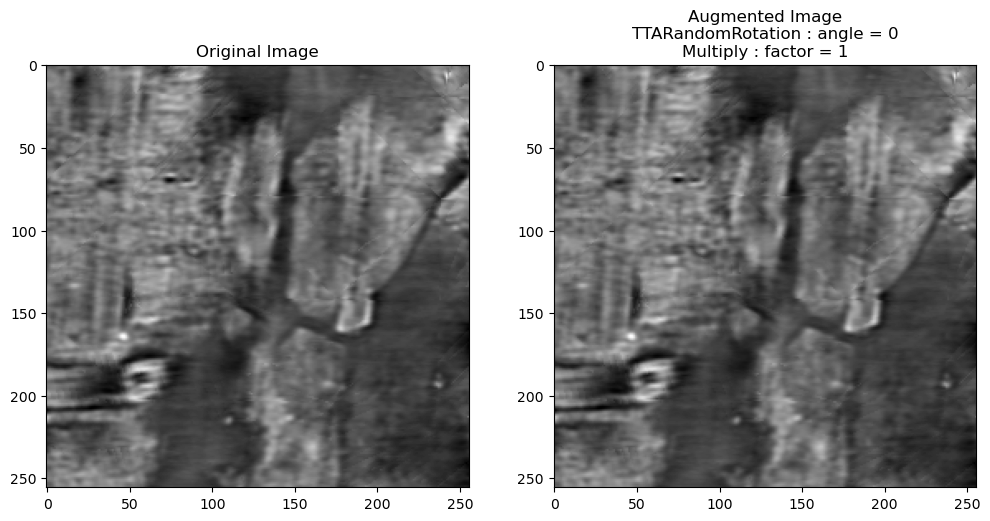

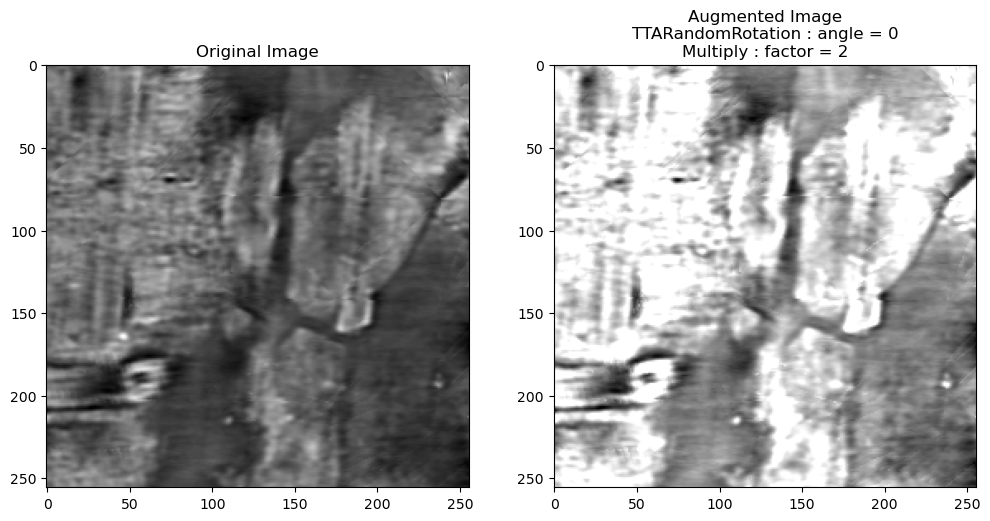

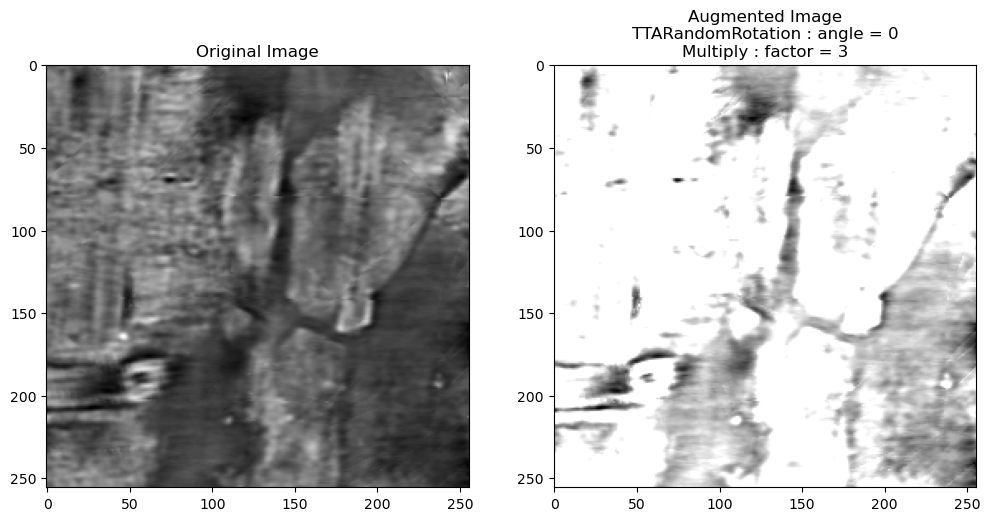

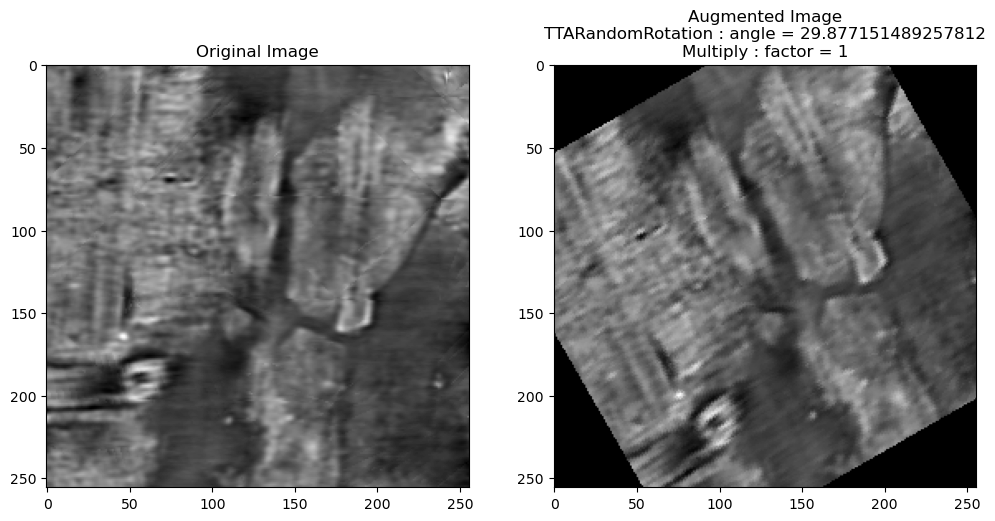

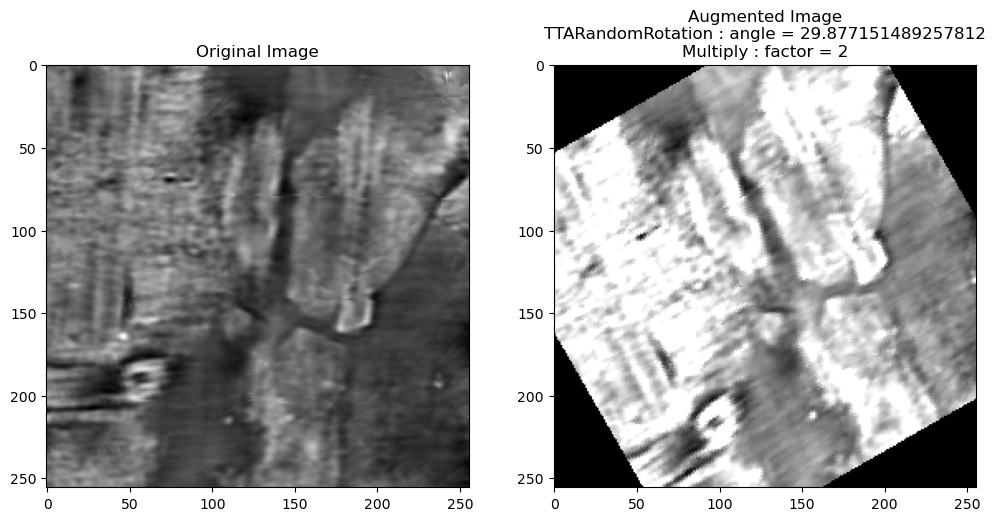

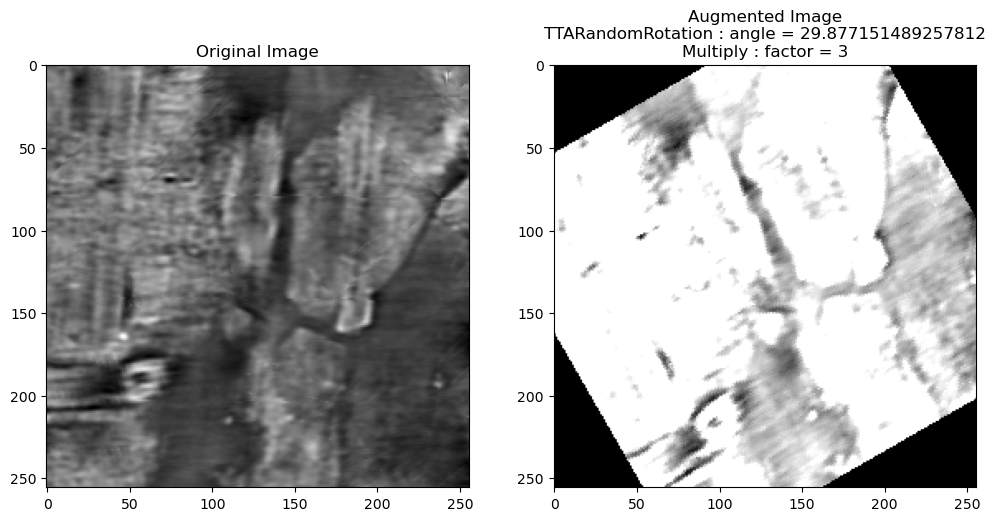

In [2]:

# Define the transformation: convert to tensor and normalize to range [0,1]
to_tensor = T.Compose([T.ToTensor()])

# Open the image file with PIL, then apply the transformation
image = Image.open('../data/tmp/10.png')
image = to_tensor(image)


transforms = tta.Compose(
    [
        # tta.HorizontalFlip(),
        # tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        TTARandomRotation(degree=180),
        tta.Multiply(factors=[2, 3]),        
    ]
)


transforms_names = [
    "\n".join([f"{str(t.__class__).split('.')[-1][:-2]} : {t.pname} = {p}" 
    for t, p in zip(transforms.aug_transforms, aug_params)])
    for aug_params in transforms.aug_transform_parameters
]
         
for i, transformer in enumerate(transforms):
    
    # print(list(map(lambda f: f.__name__, transforms.aug_transforms)))
    # augment image
    augmented_image = transformer.augment_image(image)

    # plot original and augmented images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # assuming your images are normalized in some way that might make them not displayable
    # as typical images, we use the clip function to make sure values are within [0,1]
    image_display = image.numpy().transpose((1, 2, 0))
    image_display = np.clip(image_display, 0, 1)

    aug_image_display = augmented_image.numpy().transpose((1, 2, 0))
    aug_image_display = np.clip(aug_image_display, 0, 1)

    ax[0].imshow(image_display, cmap='gray')
    ax[0].title.set_text('Original Image')

    ax[1].imshow(aug_image_display, cmap='gray')
    ax[1].title.set_text(f'Augmented Image\n{transforms_names[i]}')  # Add augmentation details to the title

    plt.show()

    # pass to model
    # model_output = model(augmented_image, another_input_data)

    # reverse augmentation for mask and label
    # deaug_mask = transformer.deaugment_mask(model_output['mask'])
    # deaug_label = transformer.deaugment_label(model_output['label'])

    # save results
#     labels.append(deaug_mask)
#     masks.append(deaug_label)

# # reduce results as you want, e.g mean/max/min
# label = mean(labels)
# mask = mean(masks)


## Compare TTA infer vs baseline infer

In [ ]:
MODELS_NAME = 'model_name.pt'
MODEL_PATH = os.path.join(MODELS_DIR, MODELS_NAME)

In [46]:
# Set the device for inference
device = get_device()

# Load the trained model
baseline_model = LightningVesuvius.load_from_checkpoint(MODEL_PATH)
tta_model = tta.SegmentationTTAWrapper(baseline_model, tta.aliases.d4_transform(), merge_mode='mean')

baseline_model = baseline_model.to(device)
tta_model = tta_model.to(device)

baseline_model.eval()
tta_model.eval()

val_dataloader = DataLoader(
    dataset=CustomDataset(FRAGMENTS_VAL_FRAGMENTS),
    batch_size=1,
    )

outputs_baseline = []
outputs_tta = []

center_coords = []
image_sizes = []
image_indices = []

# Iterate over the test data
for inputs, center_coord, image_size, image_indice in val_dataloader:
    center_coords.append(center_coord)
    image_sizes.append(image_size)
    image_indices.append(image_indice)
    
    # Move the batch to the device
    inputs = inputs.to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs_baseline.append(baseline_model(inputs))
        outputs_tta.append(tta_model(inputs))

    # Perform Metric
    # F05Score


NameError: name 'MODEL_PATH' is not defined